In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy import units as u
from astropy import constants as c
from pygsm import GlobalSkyModel2016, GlobalSkyModel

In [2]:
maps = []
freqs = np.linspace(100,200,num=10)*u.MHz
for f in freqs:
    gsm = GlobalSkyModel(freq_unit='MHz')
    gsm.generate(f)
    maps.append(gsm.generated_map_data)

In [3]:
%matplotlib qt
hp.mollview(np.log10(maps[0]),title='',notext=True,cbar=False)
#plt.savefig('GSM150MHzEQ.png')
plt.show()

In [4]:
hp.mollzoom(np.log(maps[5]))

In [5]:
npix = len(maps[0])
nside = hp.npix2nside(npix)
print nside

512


In [6]:
ipix_gc = hp.ang2pix(nside,np.pi/2.,0.)

In [7]:
ipix_gc

1569792

In [8]:
disc_gc = hp.query_disc(nside,hp.ang2vec(np.pi/2.,0.),np.radians(1.0),inclusive=True)

In [9]:
gc_spec_pt = []
gc_spec_disc = []
for m in maps:
    gc_spec_pt.append(m[ipix_gc])
    gc_spec_disc.append(m[disc_gc].mean())
gc_spec_pt = np.array(gc_spec_pt)*u.K
gc_spec_disc = np.array(gc_spec_disc)*u.K

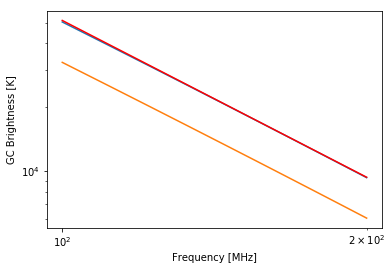

In [10]:
%matplotlib inline
plt.loglog(freqs,gc_spec_pt)
plt.plot(freqs,gc_spec_disc)
plt.plot(freqs,1.9e4*np.power(freqs/150.,-2.45),color='red')
plt.ylabel('GC Brightness [K]')
plt.xlabel('Frequency [MHz]')
plt.show()

In [11]:
# What's the HERA19 synthesized beam?  Could pull from psf produced by CASA, but let's make a guess
lmbda = (c.c/freqs).to(u.m)
b_max = 58.*u.m
FWHM = (lmbda/b_max)*u.radian
omega_B = (2.*np.pi*np.power(FWHM/2.35,2)).to(u.steradian)
print FWHM.to(u.degree)
print freqs
print omega_B

[2.96152458 2.66537212 2.42306557 2.22114344 2.05028625 1.90383723
 1.77691475 1.66585758 1.56786595 1.48076229] deg
[100.         111.11111111 122.22222222 133.33333333 144.44444444
 155.55555556 166.66666667 177.77777778 188.88888889 200.        ] MHz
[0.00303969 0.00246215 0.00203484 0.00170983 0.00145689 0.0012562
 0.00109429 0.00096178 0.00085196 0.00075992] sr


In [12]:
jy_beam_pt = np.zeros(len(gc_spec_pt))
jy_beam_disc = np.zeros(len(gc_spec_pt))
for i,f in enumerate(freqs):
    equiv = u.brightness_temperature(omega_B[i],f)
    jy_beam_pt[i] = gc_spec_pt[i].to(u.Jy,equivalencies=equiv).value
    jy_beam_disc[i] = gc_spec_disc[i].to(u.Jy,equivalencies=equiv).value

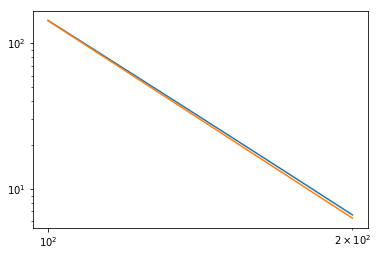

In [13]:
plt.loglog(freqs,jy_beam_pt*omega_B)
plt.loglog(freqs,23.*np.power(freqs/(150.*u.MHz),-4.5))

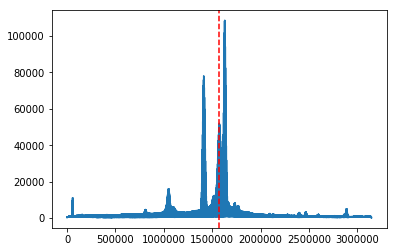

In [14]:
%matplotlib inline
plt.plot(maps[0])
plt.axvline(ipix_gc,color='red',linestyle='--')
plt.show()

In [20]:
def pwr(nu,nu0,alpha):
    return np.power(nu/nu0,-alpha)